# Democratic Debate Transcript Analysis

## Motivation: Personal Interest + Boredom

Currently, I'm studying abroad in Paris taking intersting courses in French and Philosophy. While I was procrastinated about writing my final papers of undergrad(whoo hoo), the Democratic Party debates were happening in America. I watched them on YouTube and decided to write a program to analyze the candidates' comments. I've realized The New York Times and CNN have already done their own analysis and drawn their conslusions, but I know how to write code in Python and there are several questions I'm interested in exploring that might not have appeared in those company's analysis.

Here are the links for the transcripts that I used throughout the analysis:
    First night: https://time.com/5615358/2020-first-democratic-debate-transcript/
    Second night: https://time.com/5616518/2020-democratic-debate-night-2-transcript/',

In [12]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
import re, string, nltk
from collections import defaultdict
from nltk.corpus import stopwords

In [13]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /Users/dParris/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
def readTranscripts(fileName):
    with open(fileName) as f:
        lines = f.readlines()
    f.close()
    lines = lines[4:]
    return ''.join(lines).split("\n")

In [16]:
night1 = readTranscripts('./night1.txt')
night1[0:5]

['    HOLT: Good evening, everyone. I’m Lester Holt, and welcome to the first Democratic debate to the 2020 race for president.',
 '',
 '    GUTHRIE: Hi, I’m Savannah Guthrie. And tonight, it’s our first chance to see these candidates go head to head on stage together.',
 '',
 '    GUTHRIE: We’ll be joined in our questioning time by our colleagues, Jose Diaz-Balart, Chuck Todd, and Rachel Maddow.']

In [17]:
night2 = readTranscripts('./night2.txt')
night2[0:5]

['    HOLT: And good evening once again. Welcome to the candidates and our spirited audience here tonight in the Arsht Center and across America. Tonight we continue the spirited debate about the future of the country, how to tackle our most pressing problems and getting to the heart of the biggest issues in this Democratic primary.',
 '',
 '    GUTHRIE: Tonight we are going to talk about healthcare, immigration. We’re also to dive into the economy, jobs, climate change as well.',
 '',
 '    DIAZ-BALART: As a quick rules of the road before we begin and they may sound familiar 20 candidates cal–qualified for this first debate. As we said we heard from 10 last night and we will hear from 10 more tonight. The breakdown for each night was selected at random. The candidates will have 60 seconds to answer, 30 seconds for follow-ups.']

Above is an example of how the data is structured in the .txt file. I've noticed seems that the odd indices of these first few lines are empty strings. If this is invariant, our analysis will be a bit easier. First, let's make sure this is consistent throughout the file for the first night. Running the cell below should print only if there is some non-blank odd line in the file.

In [18]:
for i in range(1, len(night1), 2):
    if night1[i] != '':
        print("not blank")

In [19]:
for i in range(1, len(night2), 2):
    if night2[i] != '':
        print("not blank")

Nothing printed, so the odd indices of `night1` and `night2` are all blank lines. Parfait!!

In [23]:
#removing the empty lines between each convo
night1 = night1[::2]
night2 = night2[::2]

Now, the fun begins. We'll make a map from each speaker to a list of their conversations.

In [25]:
def isSpeaker(s, speakers):
    return s[-1] == ":" and s[:-1] in speakers

def analyzeCandidates(lst):
    """
    input: List(str)= the conversations of each night, where each speaker has a colon in the last place
    output: dictionary mapping speakers to a list of their inputs during the night.
    """
    speakers = findSpeakers(lst)
    speakersToText = {}
    for s in speakers:
        speakersToText[s] = []
        #print('\t', s)
        
    wordByWord = ''.join(lst).split()
        
    start = 0
    end = 1
    while end < len(wordByWord):
        speaker = wordByWord[start][:-1]
        mightSpeak = wordByWord[end]
        if isSpeaker(mightSpeak, speakers):
            currLst = speakersToText[speaker]
            currLst.append(' '.join(wordByWord[start + 1:end]))
            speakersToText[speaker] = currLst
            start = end
        end += 1
    return speakersToText   

In [29]:
def findSpeakers(lst, deBlasio=False):
    speakers = set()
    for s in lst:
        if ":" in s:
            idx = s.index(":")
            if idx < 20:
                speakers.add(s[:idx].strip())
    #================ helping Mayor De Blasio have a voice ===============#
    if deBlasio:
        speakers.remove("DE BLASIO")
        speakers.add("DEBLASIO")
    #================ helping Mayor De Blasio have a voice ===============#
    return speakers

In [30]:
candidates1 = analyzeCandidates(night1)
for candidate in candidates1.keys():
    print(candidate, len(candidates1[candidate]))

KLOBUCHAR 7
O’ROURKE 15
DELANEY 12
RYAN 12
INSLEE 5
GUTHRIE 11
BOOKER 10
(UNKNOWN) 2
DIAZ-BALART 13
GABBARD 3
DE BLASIO 0
MADDOW 18
WARREN 9
TODD 41
CASTRO 7
HOLT 25


UH OH, apparently Mayor De Blasio didn't make any inputs in the entire debate?!? The issue is that his name has a space in it and we split the conversation by spaces thus "DE BLASIO" is never considered as we seek candidate inputs. Perhaps we should replace "DE BLASIO" with "DEBLASIO" to ensure his inputs are captured and we can still split by spaces, since everthing else seems to be working well. Let's handle this by adding a few lines of code to `analyzeCandidates`.

In [31]:
def switchDeBlasio(listOfWords):
    i = 0
    while i < len(listOfWords):
        if listOfWords[i] == "DE" and listOfWords[i + 1] == "BLASIO:":
            listOfWords.pop(i)
            listOfWords[i] = "DEBLASIO:"
        i += 1
    return listOfWords

In [32]:
def analyzeCandidates2(lst, night1=False):
    """
    input: List(str)= the conversations of each night, where each speaker has a colon in the last place
    output: dictionary mapping speakers to a list of their inputs during the night.
    """
    
    speakers = findSpeakers(lst, night1)
    speakersToText = {}
    for s in speakers:
        speakersToText[s] = []
        #print('\t', s)
    
    wordByWord = switchDeBlasio(''.join(lst).split())
    
    start = 0
    end = 1
    while end < len(wordByWord):
        speaker = wordByWord[start][:-1]
        mightSpeak = wordByWord[end]
        if isSpeaker(mightSpeak, speakers):
            currLst = speakersToText[speaker]
            currLst.append(' '.join(wordByWord[start + 1:end]))
            speakersToText[speaker] = currLst
            start = end
        end += 1
    return speakersToText  

In [33]:
candidates1 = analyzeCandidates2(night1, True)
for candidate in candidates1.keys():
    print(candidate, "made", len(candidates1[candidate]), "contributions.")

KLOBUCHAR made 7 contributions.
O’ROURKE made 15 contributions.
DELANEY made 12 contributions.
RYAN made 12 contributions.
INSLEE made 5 contributions.
DEBLASIO made 8 contributions.
GUTHRIE made 11 contributions.
BOOKER made 10 contributions.
(UNKNOWN) made 2 contributions.
DIAZ-BALART made 13 contributions.
GABBARD made 3 contributions.
MADDOW made 18 contributions.
WARREN made 9 contributions.
TODD made 41 contributions.
CASTRO made 7 contributions.
HOLT made 25 contributions.


Great, we've put that fire out! I'm going to remove the input that was attributed to the Announcer. Let's see what was said by unknown. I want to remove it, but it's important to ensure there aren't some juicy details there.

In [16]:
candidates1["(UNKNOWN)"]

['That’s a false claim.',
 'Thank you.',
 'Jose…',
 'Yes, it was.',
 'Their mikes are on.',
 'Chuck…']

In [17]:
candidates1['ANNOUNCER']

['Tonight, round one. New Jersey Senator Cory Booker. Former Housing Secretary Julian Castro. New York City Mayor Bill De Blasio. Former Maryland Congressman John Delaney. Hawaii Congresswoman Tulsi Gabbard. Washington Governor Jay Inslee. Minnesota Senator Amy Klobuchar. Former Texas Congressman Beto O’Rourke. Ohio Congressman Tim Ryan. And Massachusetts Senator Elizabeth Warren. From NBC News, “Decision 2020,” the Democratic candidates debate, live from the Adrienne Arsht Performing Arts Center in Miami, Florida.']

Looks pretty irrelevant to our analysis. So we'll ignore those inputs as well.

In [18]:
candidates1.pop('ANNOUNCER', None)
candidates1.pop('(UNKNOWN)', None)

['That’s a false claim.',
 'Thank you.',
 'Jose…',
 'Yes, it was.',
 'Their mikes are on.',
 'Chuck…']

There were 5 moderators during the debates, so perhaps we should split this speakers set into moderators and candidates.

In [19]:
moderators = {'GUTHRIE', 'HOLT', 'MADDOW', 'TODD', 'DIAZ-BALART'}
candidates = set()

In [20]:
for speaker in list(candidates1):
    if speaker not in moderators:
        candidates.add(speaker)
len(candidates)

10

Great! So now we have the candidates of the first evening all saved in the variable `candidates`. Now let's add the data from the second evening of debates!

In [21]:
candidates2 = analyzeCandidates2(night2)
for candidate in candidates2.keys():
    print(candidate, "made", len(candidates2[candidate]), "contributions.")

BENNET made 31 contributions.
GILLIBRAND made 38 contributions.
WILLIAMSON made 26 contributions.
MADDOW made 43 contributions.
BALART made 16 contributions.
HICKENLOOPER made 10 contributions.
GUTHRIE made 46 contributions.
SANDERS made 49 contributions.
HARRIS made 45 contributions.
SWALWELL made 33 contributions.
BIDEN made 43 contributions.
DIAZ-BALART made 30 contributions.
TODD made 88 contributions.
UNKNOWN made 9 contributions.
HOLT made 45 contributions.
BUTTIGIEG made 22 contributions.
DIAZ BALART made 0 contributions.
YANG made 7 contributions.


Seems like "DIAZ BALART" didnt make any contributions but he is a moderator, and his name is duplicated. So we'll add "DIAZ BALART" and "BALART" to our `moderators` set.

In [22]:
moderators.add("DIAZ BALART")
moderators.add("BALART")

Again, "UNKNOWN" made no import contributions, so we'll just drop this from our analysis.

In [23]:
candidates2.pop('UNKNOWN', None)

['Yeah.',
 'Yeah.',
 '(INAUDIBLE) comment–',
 'been part of the issue–',
 '–Wait for evolution on these issues.',
 'Can I–',
 '(INAUDIBLE) lifetime, (INAUDIBLE) for all and today–',
 '–No–',
 '–That’s inventive enough–']

In [24]:
for speaker in list(candidates2):
    if speaker not in moderators:
        candidates.add(speaker)
len(candidates)

20

Now, we have all of candidates in `candidates` and their inputs for each evening are stored in the variables `candidates1` and `candidates2`.

# Questions of Interest

1. What were the top 5 words used most frequently during the debate? 
2. For each candidate, what were their 5 most frequently used words? How about top 5 bigrams? Top 5 trigrams?
3. How many words did each candidate say? Unique words? Average length of words used?
4. People invoked: How many times was Mitch McConnell mentioned? How about Trump? Nancy Pelosi? Barack Obama?
5. Locations invoked: How many times was North Korea mentioned? Russia? China? Iran? Sudan? Afghanistan?
6. How many times did a candidate mention another candidate, providing them at least 30 seconds to respond?
7. How positive was each candidate's message?

## 1: Top 5 Words

This analysis would be easier to conduct using `night1` and `night2` since they already contain all words from each evening. First we'll see what the top 5 words are from each night and we'll be able to if they discussed the same topics each night.

In [25]:
apostrophe = nltk.word_tokenize(' '.join(night1))[8]
apostrophe

'’'

In [26]:
def countWords(lstOfConvos):
    """
    Input: List(str) a list of conversations, not tokenized
    Output: dictionary (key: word, value: number of times word appeard in the convos)
    """
    stripped = removePunctuation(' '.join(lstOfConvos))
    tokens = removeContractions(nltk.word_tokenize(''.join(stripped)))
    stopWords = set(stopwords.words('english'))
    word_counts = defaultdict(int)
    for word in tokens:
        word = word.lower()
        if word not in stopWords and len(word) > 4 and word.upper() not in candidates \
            and word.upper() not in moderators:
            word_counts[word] += 1
        
    return word_counts
    
def topKWords(lstOfConvos, k=5):
    """
    Input: List(str) a list of conversations, not tokenized; k(int) number of words to return
    Output: tuple (top K words, number of times the top ) 
    """
    sorted_counts = sorted(countWords(lstOfConvos).items(), key=lambda kv: kv[1])
    
    words, counts = [], []
    for k, v in list(sorted_counts)[::-1][:k]:
        words.append(k)
        counts.append(v)
    
    return np.array(words), np.array(counts)

def findTopK(wordCounts):
    sorted_counts = sorted(wordCounts.items(), key=lambda kv: kv[1])
    topKWords = [k for k, _ in list(sorted_counts)[::-1][:k]]
    topKCounts = [v for _, v in list(sorted_counts)[::-1][:k]]
    
    return topKWords, np.array(topKCounts)   
    
def removePunctuation(lstOfWords):
    table = str.maketrans('', '', string.punctuation)
    return [w.translate(table) for w in lstOfWords]

def removeContractions(tokens):
    i = 0
    while i < len(tokens):
        token = tokens[i]
        if token == apostrophe:
            tokens.pop(i + 1)
            tokens.pop(i)
            tokens.pop(i - 1)
        else:
            i += 1
    return tokens
   

In [27]:
# maps candidates to a count of all the words they used
countsByCandidates = {}
for cand in candidates:
    try:
        countsByCandidates[cand] = countWords(candidates1[cand])
    except:
        countsByCandidates[cand] = countWords(candidates2[cand])

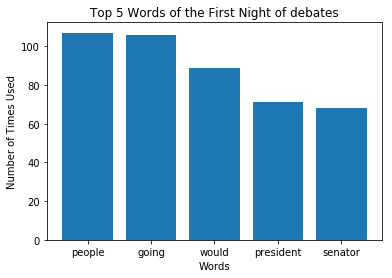

In [28]:
night1Top5, night1Top5counts = topKWords(night1)
plt.bar(night1Top5, night1Top5counts)
plt.title("Top 5 Words of the First Night of debates")
plt.xlabel("Words")
plt.ylabel("Number of Times Used");

This analysis is including the words of the mooderators which may explain why 'president' and 'senator' are in the top 5 words as they present questions to the candidates. First, let's analyze the number of times each of the top 5 from each night appeared in each candidates. Then we'll see what the top 5 of each candidate was.

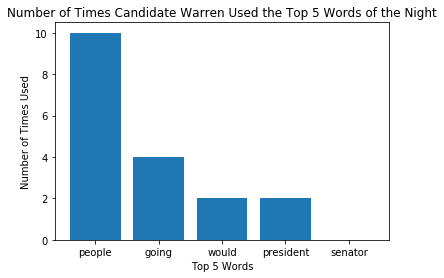

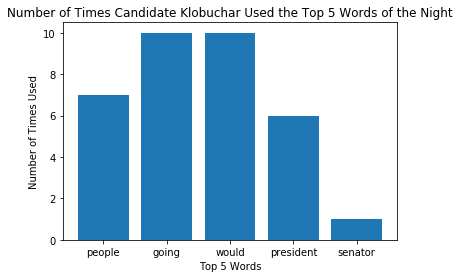

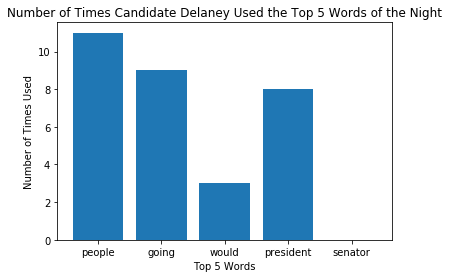

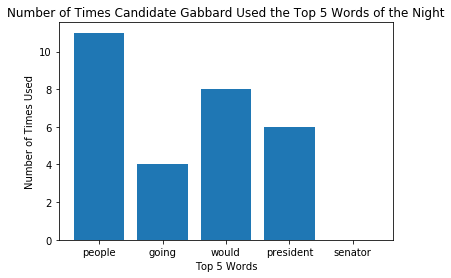

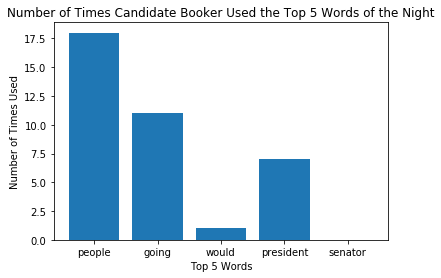

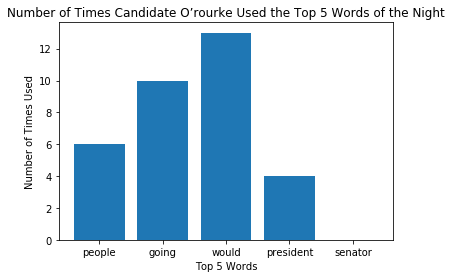

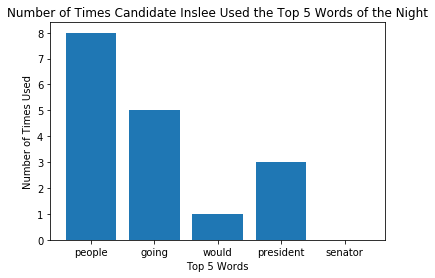

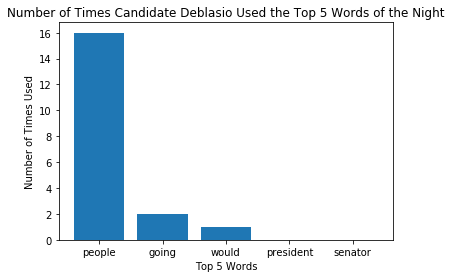

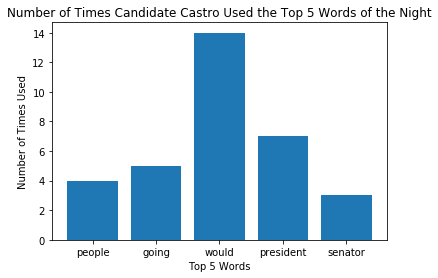

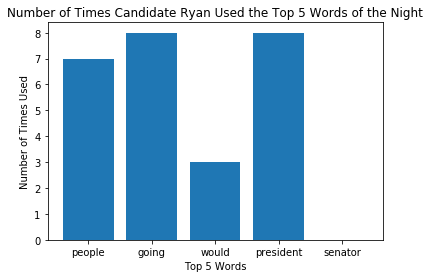

In [29]:
for speaker in candidates1.keys():
    if speaker in candidates:
        counts = countsByCandidates[speaker]
        candCount = {}
        for word in night1Top5:
            candCount[word] = counts[word]
            
        plt.bar(candCount.keys(), candCount.values())
        plt.title("Number of Times Candidate " + speaker.capitalize() + " Used the Top 5 Words of the Night")
        plt.xlabel("Top 5 Words")
        plt.ylabel("Number of Times Used")
    plt.show();

Only 2 candidates actually said senator, perhaps we should find the top 5 words of the debates and exclude words said by commentators.

# 2. Top 5 Unigrams of each Candidate

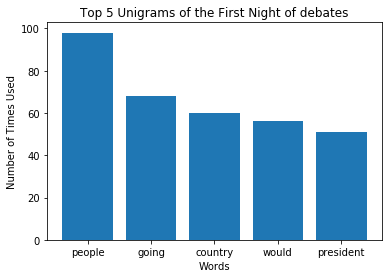

In [30]:
words = []
for cand in candidates:
    if cand in candidates1.keys():
        words += candidates1[cand]
candOnly, candOnlyCounts = topKWords(words)
plt.bar(candOnly, candOnlyCounts)
plt.title("Top 5 Unigrams of the First Night of debates")
plt.xlabel("Words")
plt.ylabel("Number of Times Used");

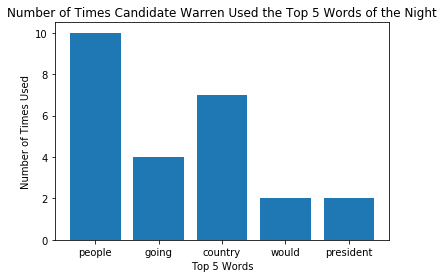

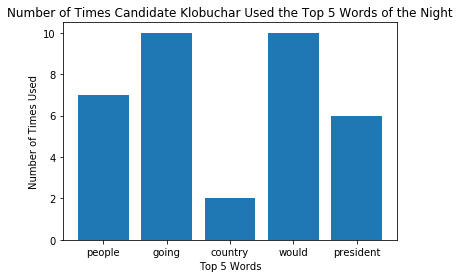

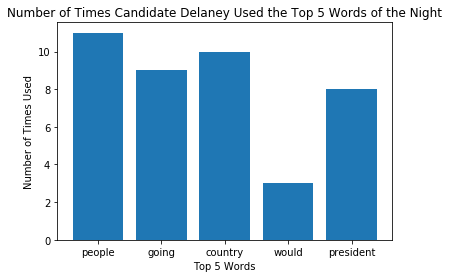

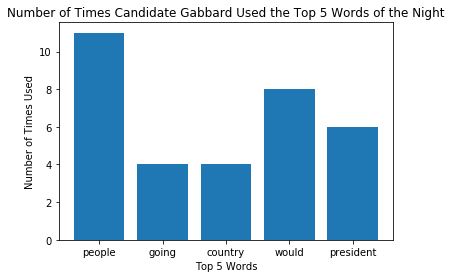

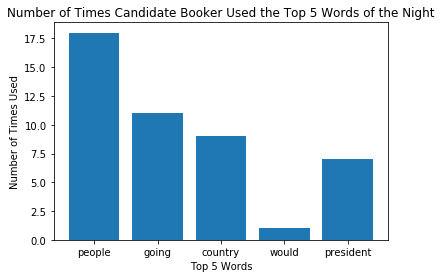

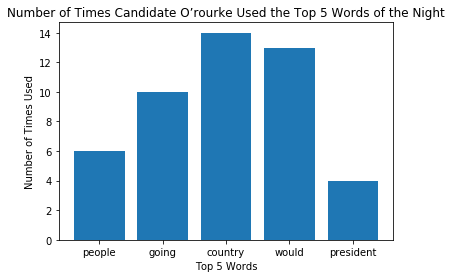

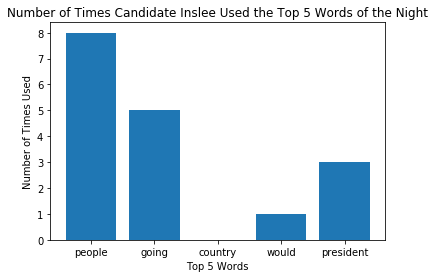

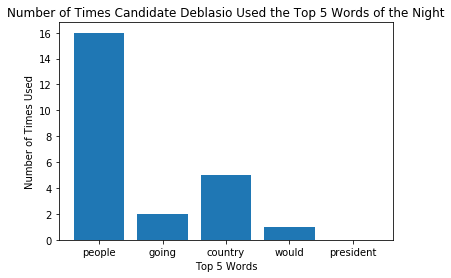

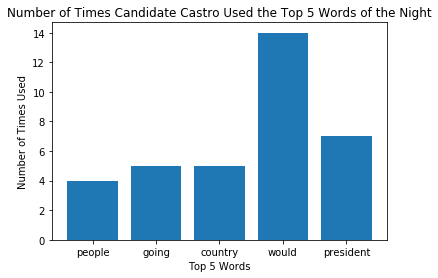

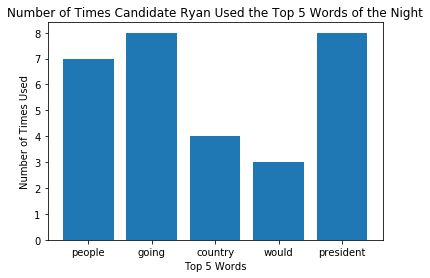

In [31]:
for speaker in candidates1.keys():
    if speaker in candidates:
        counts = countsByCandidates[speaker]
        candCount = {}
        for word in candOnly:
            candCount[word] = counts[word]
            
        plt.bar(candCount.keys(), candCount.values())
        plt.title("Number of Times Candidate " + speaker.capitalize() + " Used the Top 5 Words of the Night")
        plt.xlabel("Top 5 Words")
        plt.ylabel("Number of Times Used")
    plt.show();

# Second Night

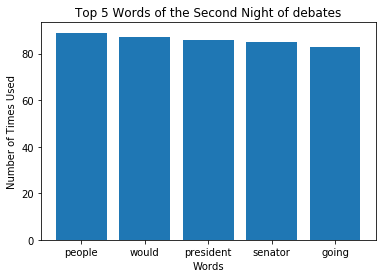

In [32]:
night2Top5, night2Top5counts = topKWords(night2)
plt.bar(night2Top5, night2Top5counts)
plt.title("Top 5 Words of the Second Night of debates")
plt.xlabel("Words")
plt.ylabel("Number of Times Used");

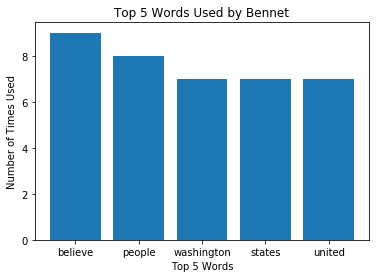

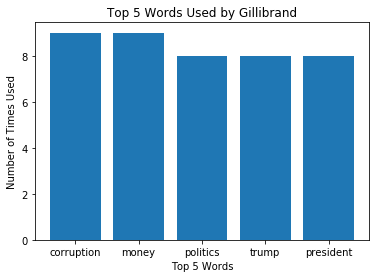

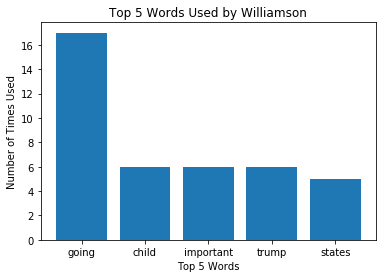

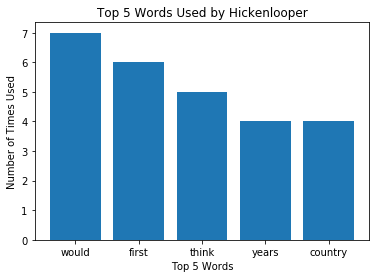

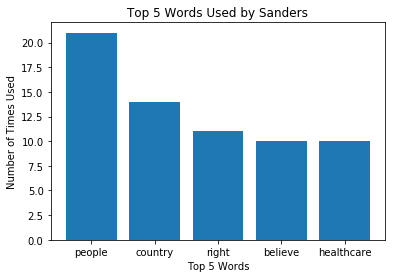

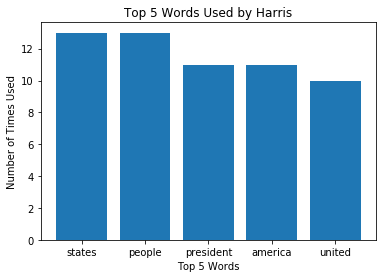

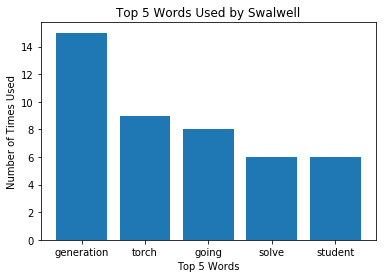

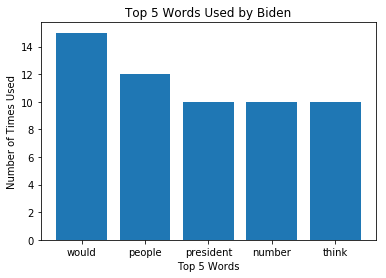

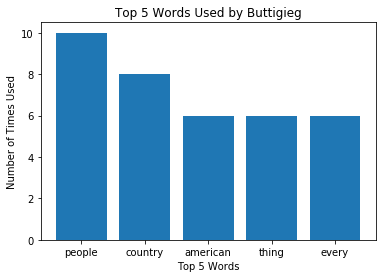

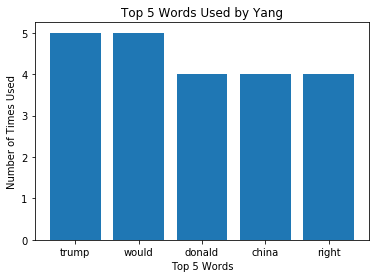

In [33]:
for candidate in candidates2.keys():
    if candidate in candidates:
        convos = candidates2[candidate]
        candidateTop5, candidateTop5counts = topKWords(convos)
        plt.bar(candidateTop5, candidateTop5counts)
        plt.title("Top 5 Words Used by " + candidate.capitalize())
        plt.xlabel("Top 5 Words")
        plt.ylabel("Number of Times Used")
    plt.show();
    

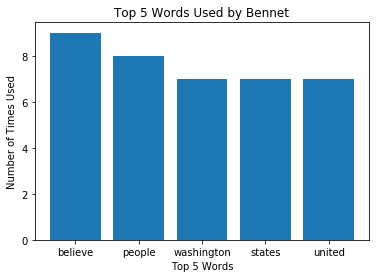

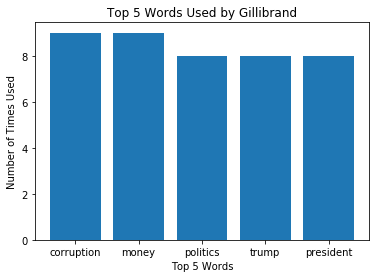

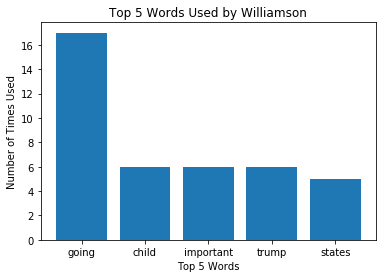

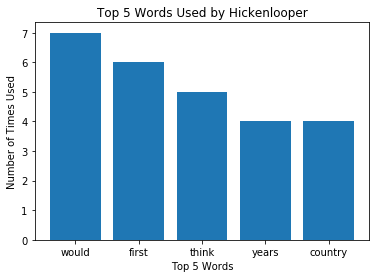

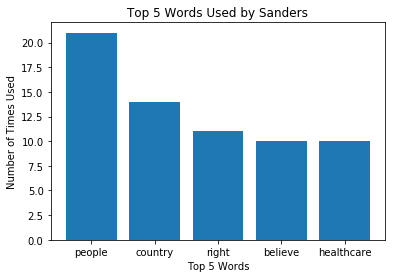

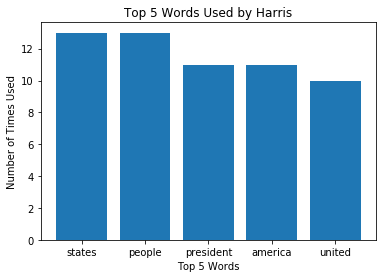

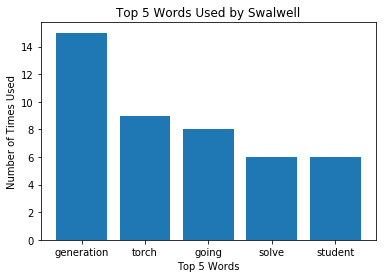

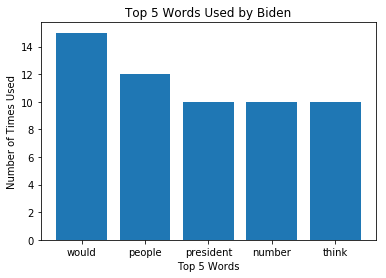

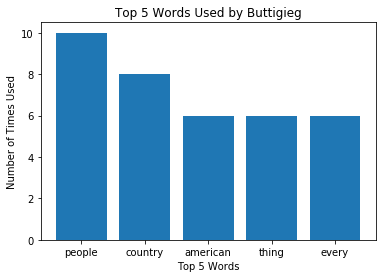

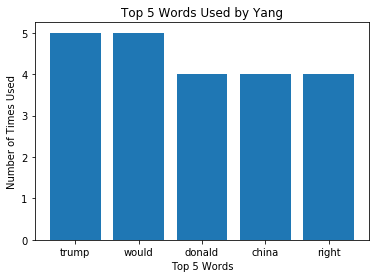

In [34]:
for candidate in candidates2.keys():
    if candidate in candidates:  
        convos = candidates2[candidate]
        candidateTop5, candidateTop5counts = topKWords(convos)
        plt.bar(candidateTop5, candidateTop5counts)
        plt.title("Top 5 Words Used by " + candidate.capitalize())
        plt.xlabel("Top 5 Words")
        plt.ylabel("Number of Times Used")
    plt.show();

# 3. Word Counts

In [40]:
convos = {}
for cand in candidates1.keys():
    if cand in candidates:
        convos[cand] = candidates1[cand]
for cand in candidates2.keys():
    if cand in candidates:
        convos[cand] = candidates2[cand]

In [59]:
counts = []
cands = []
for candidate in convos.keys():
    cands.append(candidate)
    counts.append(len(set(countWords(convos[candidate]))))

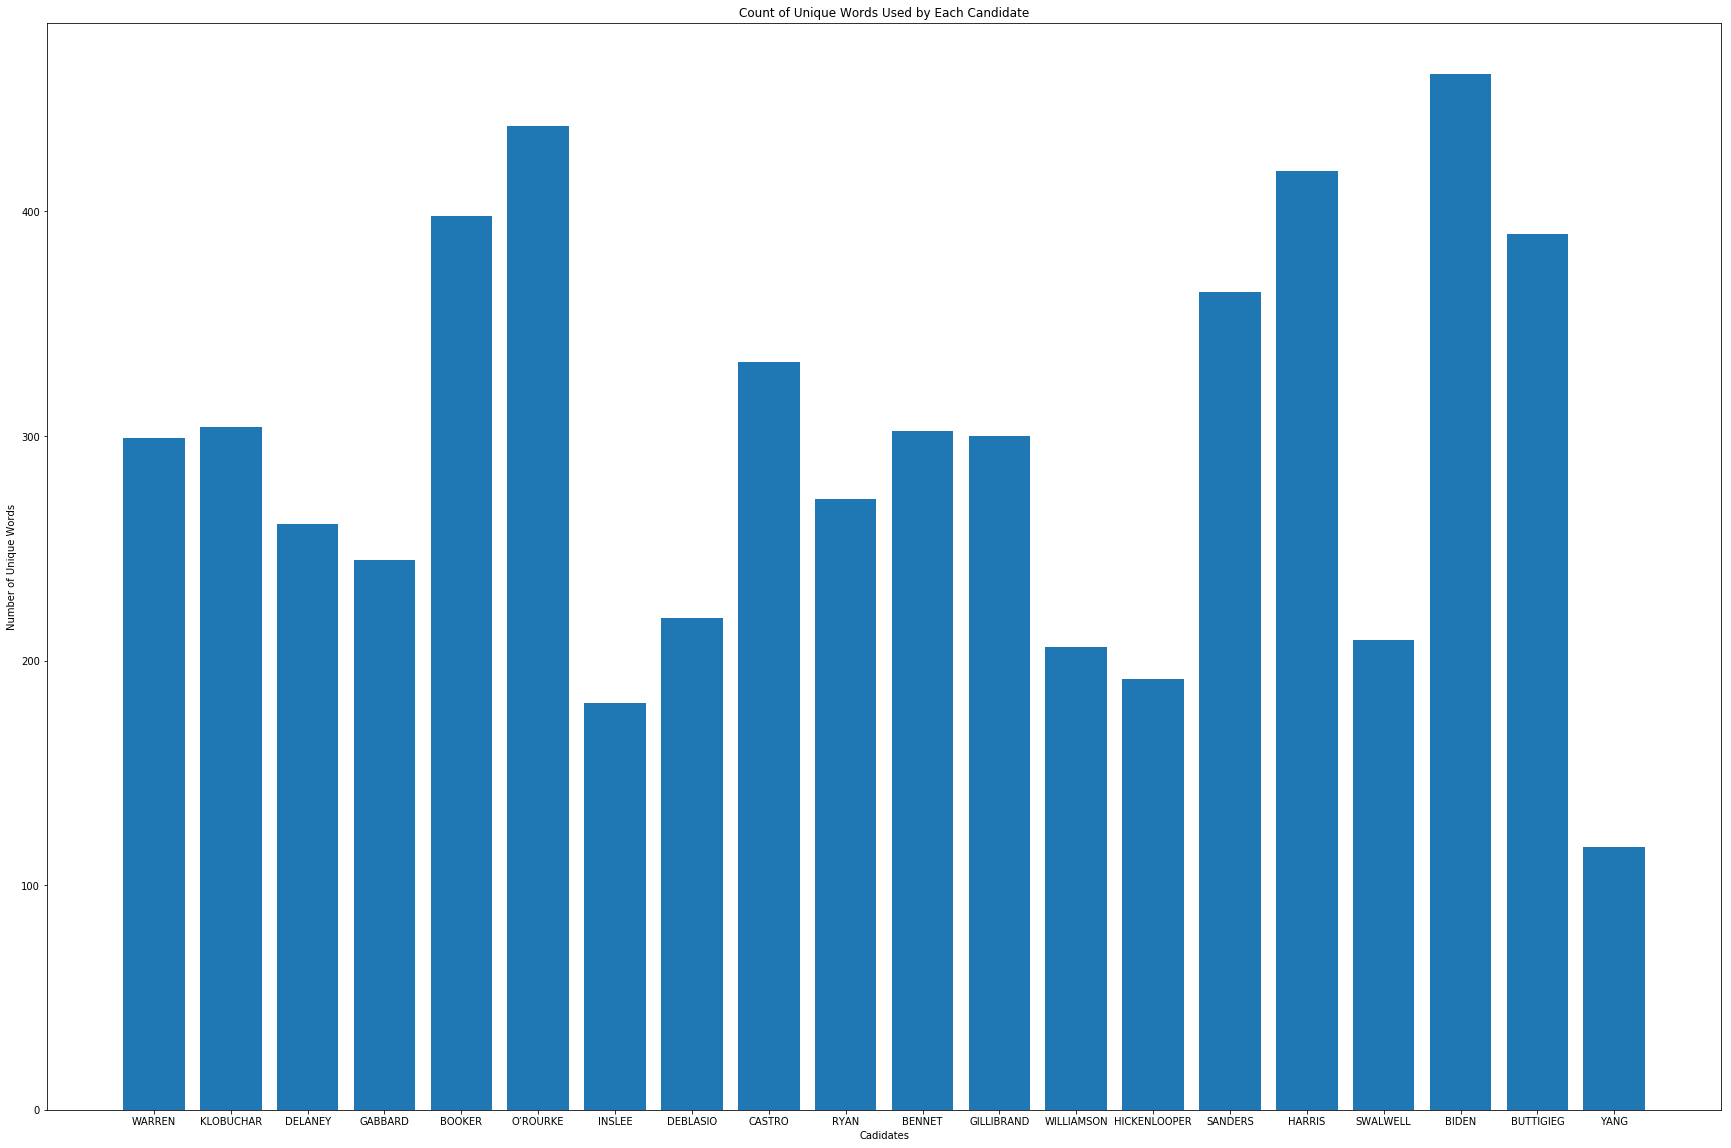

In [60]:
plt.figure(figsize=(30,20))
plt.xlabel("Cadidates")
plt.ylabel("Number of Unique Words")
plt.title("Count of Unique Words Used by Each Candidate")
plt.bar(cands, counts);

Some candidates were able to speak more times than others, so this plot may be misleading since Joe Biden may have the most unique words because he was able to speak for longer than Andrew Yang. Actually, everyone spoke more than Andrew Yang. So let's plot the frequency of unique words for each candidate in relation to other words they used.

In [64]:
all_words = []
for candidate in cands:
    convo = countWords(convos[candidate])
    count = sum(convo.values())
    all_words.appe

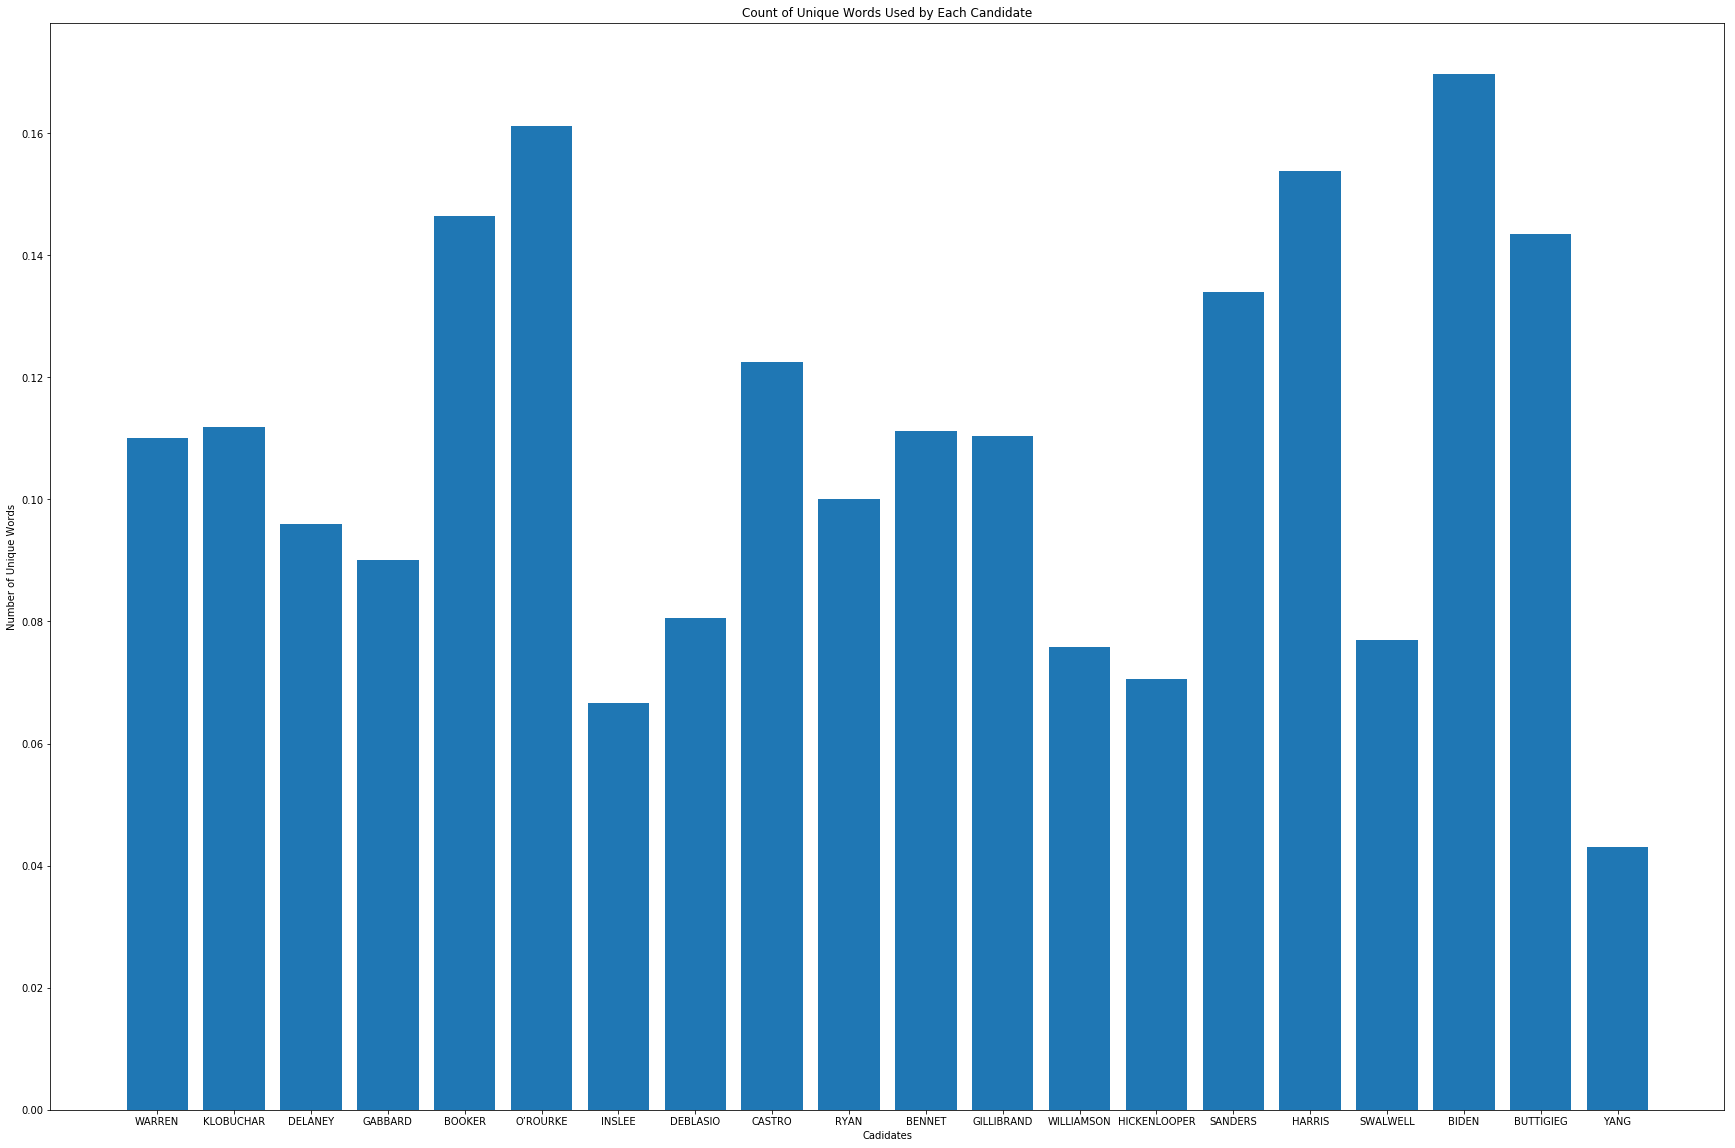

In [66]:
plt.figure(figsize=(30,20))
plt.xlabel("Cadidates")
plt.ylabel("Number of Unique Words")
plt.title("Count of Unique Words Used by Each Candidate")
plt.bar(cands, np.array(counts)/len(all_words));

## 7 : Sentiment Analysis

It turns out that we can use the words in each candidate's response to calculate a measure of their sentiment of the statement. For example, the sentence "I love America!" has positive sentiment, whereas the sentence "I hate taxes!" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of their statements. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. Run the following cell to show the first few rows of the lexicon:

In [35]:
print(''.join(open("vader_lexicon.txt").readlines()[:10]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



As you can see, the lexicon contains emojis too! The first column of the lexicon is the token, or the word itself. The second column is the polarity of the word, or how positive / negative it is.

(How did they decide the polarities of these words? What are the other two columns in the lexicon? See the link above.)

Next, we'll read the lexicon into a DataFrame called sent. The indices of the DF are the tokens in the lexicon.

In [36]:
tokens, polarites = [], []
for line in open("vader_lexicon.txt").readlines():
    line = line.split("\t")
    token, polarity = line[0], float(line[1])
    tokens.append(token)
    polarites.append(polarity)
sent = pd.DataFrame()
sent['token'] = tokens
sent['polarity'] = polarites
sent = sent.set_index('token')
sent.tail(25)

,polarity
token,
yeees,1.7
yep,1.2
yes,1.7
youthful,1.3
yucky,-1.8
yummy,2.4
zealot,-1.9
zealots,-0.8
zealous,0.5


In [37]:
sent.loc["disagree"]["polarity"]

-1.6

In the lexicon, all the tokens are lowercase so lets change all of the candidates speech to lowercase. Below I've made some helper methods to assist with our Sentiment Analysis. Since lexicon has no use for punctuation, we must remove them.

In [38]:
tokens = set(sent.reset_index()["token"])
def removePunctuations(s):
    pattern = re.compile(r'[^\w\s]')
    return pattern.sub('', s)

def findPolarity(lst_of_words):
    ret = 0
    for word in lst_of_words:
        if word in tokens:
            ret += sent.loc[word]["polarity"]
    return ret

In [39]:
polarities = {}
for speaker in speakers:
    for speech in speakersToText2[speaker]:
        if speaker in polarities:
            lst = polarities[speaker]
        else:
            lst = []
        lst.append(findPolarity(removePunctuations(speech.lower()).split()))
        polarities[speaker] = lst

NameError: name 'speakers' is not defined

In [ ]:
for speaker in speakers:
    print(speaker, np.mean(polarities[speaker]))

In [ ]:
findPolarity(removePunctuations(speakersToText2["BOOKER"][0]).lower().split())